## Prompt Engineering for Question Answering (QA)

This notebook explores different types of prompts on 3 local host llms for the task of **Question Answering (QA)** using **SQUAD** dataset, and compare their performance.
- Zero-shot prompting
- Few-shot prompting
- Role-based prompting
- Chain-of-Thought prompting

## 1. Load and Explore Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
# Load the SQuAD dataset
from datasets import load_dataset

dataset = load_dataset("squad", trust_remote_code=True)

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [4]:
for sample in dataset['train'].select(range(100,110)):
    print(sample)

{'id': '573387acd058e614000b5cb5', 'title': 'University_of_Notre_Dame', 'context': 'One of the main driving forces in the growth of the University was its football team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918. Under Rockne, the Irish would post a record of 105 wins, 12 losses, and five ties. During his 13 years the Irish won three national championships, had five undefeated seasons, won the Rose Bowl in 1925, and produced players such as George Gipp and the "Four Horsemen". Knute Rockne has the highest winning percentage (.881) in NCAA Division I/FBS football history. Rockne\'s offenses employed the Notre Dame Box and his defenses ran a 7–2–2 scheme. The last game Rockne coached was on December 14, 1930 when he led a group of Notre Dame all-stars against the New York Giants in New York City.', 'question': 'In what year did the team lead by Knute Rockne win the Rose Bowl?', 'answers': {'text': ['1925'], 'answer_start': [354]}}
{'id': '573387acd058e614000b5

- Due to resource constraints, we will only use the first 1000 samples from the validation set.

In [5]:

squad = dataset['validation'].select(range(1000))
squad

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})

## 2. Define prompt templates

In [6]:
# Define prompt templates
prompt_templates = {
    "zero_shot": """
Context: {context}
Question: {question}
Answer(brief and accurate): 
    """,
    
    "few_shot": """
Below are some examples of question answering based on a given context. Follow the same format to answer.

Example 1:
Context: The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.
Question: What is the primary seminary of the Congregation of the Holy Cross?
Answer(brief and accurate): Moreau Seminary

Example 2:
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: What is in front of the Notre Dame Main Building?
Answer(brief and accurate): a copper statue of Christ

Example 3:
Context: One of the main driving forces in the growth of the University was its football team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918. Under Rockne, the Irish would post a record of 105 wins, 12 losses, and five ties. During his 13 years the Irish won three national championships, had five undefeated seasons, won the Rose Bowl in 1925, and produced players such as George Gipp and the "Four Horsemen". Knute Rockne has the highest winning percentage (.881) in NCAA Division I/FBS football history. Rockne's offenses employed the Notre Dame Box and his defenses ran a 7–2–2 scheme. The last game Rockne coached was on December 14, 1930 when he led a group of Notre Dame all-stars against the New York Giants in New York City.
Question: How many years was Knute Rockne head coach at Notre Dame?
Answer(brief and accurate): 13

Now answer the following:
Context: {context}
Question: {question}
Answer(brief and accurate):
    """,
    
    "role_based": """
You are an expert reading comprehension system that can accurately find answers in text.
Context: {context}
Question: {question}
Based on the context, the answer is(briefly and accurately, no full sentence, no ending punctuation):
    """,

    "cot": """
Context: {context}
Question: {question}

Let's think step by step to find the answer.

Step 1: Understand the question.
Step 2: Locate relevant information in the context.
Step 3: Extract the exact answer from the matched sentence.

Final Answer (brief and accurate, no thinking steps): 
    """
}

In [7]:
# # Define prompt templates
# prompt_templates = {
#     "zero_shot": """
# Below is a piece of text followed by a question about that text.
# Please extract the precise answer from the text. Your answer should be brief, accurate, and directly from the context without adding explanations.

# Context: {context}

# Question: {question}

# Answer (extract the exact answer from the context, be brief and precise):
#     """,
    
#     "few_shot": """
# Below are some examples of question answering based on a given context. Follow the same format to answer.

# Example 1:
# Context: The Norman invasion of England in 1066 was led by William, Duke of Normandy. William was crowned king of England on Christmas Day, 1066, at Westminster Abbey. The Norman Conquest was the last successful foreign invasion of England.
# Question: Who led the Norman invasion of England in 1066?
# Answer(brief and accurate): William, Duke of Normandy

# Example 2:
# Context: The Louvre Museum is the world's largest art museum and a historic monument in Paris, France. A central landmark of the city, it is located on the Right Bank of the Seine. Approximately 38,000 objects from prehistory to the 21st century are exhibited over an area of 72,735 square meters.
# Question: Where is the Louvre Museum located?
# Answer(brief and accurate): Paris, France

# Example 3:
# Context: Photosynthesis is a process used by plants and other organisms to convert light energy into chemical energy that can later be released to fuel the organisms' activities. This chemical energy is stored in carbohydrate molecules, such as sugars, which are synthesized from carbon dioxide and water. Oxygen is also released as a waste product. Plants absorb light primarily using the pigment chlorophyll.
# Question: Why do plants perform photosynthesis?
# Answer(brief and accurate): to convert light energy into chemical energy

# Example 4:
# Context: One of the main driving forces in the growth of the University was its football team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918. Under Rockne, the Irish would post a record of 105 wins, 12 losses, and five ties. During his 13 years the Irish won three national championships, had five undefeated seasons, won the Rose Bowl in 1925, and produced players such as George Gipp and the "Four Horsemen". Knute Rockne has the highest winning percentage (.881) in NCAA Division I/FBS football history. Rockne's offenses employed the Notre Dame Box and his defenses ran a 7–2–2 scheme. The last game Rockne coached was on December 14, 1930 when he led a group of Notre Dame all-stars against the New York Giants in New York City.
# Question: How many years was Knute Rockne head coach at Notre Dame?
# Answer(brief and accurate): 13

# Now answer the following:
# Context: {context}
# Question: {question}
# Answer(brief and accurate):
#     """,
    
#     "role_based": """
# You are an expert reading comprehension system that can accurately find answers in text.
# Context: {context}
# Question: {question}
# Based on the context, the answer is(briefly and accurately, no full sentence, no ending punctuation):
#     """,

#     "cot": """
# Context: {context}
# Question: {question}

# Let's think step by step to find the answer.

# Step 1: Understand the question.
# Step 2: Locate relevant information in the context.
# Step 3: Extract the exact answer from the matched sentence.

# Final Answer (brief and accurate): 
#     """
# }

## 3. Helper Functions

### 3.1 Call Local LMStudio model

In [8]:
# Function to call local LMStudio model
import requests


def call_lmstudio_api(prompt, url="http://localhost:1234/v1/chat/completions"):
    headers = {
        "Content-Type": "application/json"
    }
    data = {
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.0,
        "max_tokens": 100
    }
    
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return "Error in API call"


### 3.2 Evaluate Answer

In [9]:
# from collections import Counter

# def evaluate_answer(prediction, ground_truth):
#     # Exact Match
#     exact_match = int(prediction.lower().rstrip('.!?,;:') == ground_truth.strip().lower().rstrip('.!?,;:'))
    
#     pred_tokens = prediction.lower().rstrip('.!?,;:').split()
#     truth_tokens = ground_truth.lower().rstrip('.!?,;:').split()
    
#     if not pred_tokens or not truth_tokens:
#         return {"exact_match": exact_match, "f1": 0.0}
    
#     pred_counter = Counter(pred_tokens)
#     truth_counter = Counter(truth_tokens)
    
#     common = pred_counter & truth_counter 
#     num_same = sum(common.values())
    
#     if num_same == 0:
#         return {"exact_match": exact_match, "f1": 0.0}
    
#     precision = num_same / len(pred_tokens)
#     recall = num_same / len(truth_tokens)
#     f1 = 2 * precision * recall / (precision + recall)
    
#     return {
#         "exact_match": exact_match,
#         "f1": round(f1, 4)
#     }


In [10]:
import collections
import re
import string


def evaluate_answer(prediction, ground_truth):
    """
    Evaluates the prediction against the ground truth answer using the SQuAD evaluation metrics.
    
    Args:
        prediction: The model's predicted answer string
        ground_truth: The reference answer string
        
    Returns:
        Dictionary containing exact_match (0 or 1) and f1 score (between 0 and 1)
    """
    # Normalize both prediction and ground truth
    def normalize_text(s):
        """Lower text and remove punctuation, articles and extra whitespace."""
        def remove_articles(text):
            regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
            return re.sub(regex, ' ', text)
        
        def white_space_fix(text):
            return ' '.join(text.split())
        
        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)
        
        def lower(text):
            return text.lower()
        
        return white_space_fix(remove_articles(remove_punc(lower(s))))
    
    def get_tokens(s):
        if not s:
            return []
        return normalize_text(s).split()
    
    # Compute exact match - binary score (1 if the normalized strings match exactly, 0 otherwise)
    normalized_prediction = normalize_text(prediction)
    normalized_ground_truth = normalize_text(ground_truth)
    exact_match = int(normalized_prediction == normalized_ground_truth)
    
    # Compute F1 score based on token overlap
    prediction_tokens = get_tokens(prediction)
    ground_truth_tokens = get_tokens(ground_truth)
    
    # Handle empty predictions or ground truth
    if len(prediction_tokens) == 0 or len(ground_truth_tokens) == 0:
        return {"exact_match": exact_match, "f1": 0.0}
    
    # Count token overlap using Counter
    common = collections.Counter(prediction_tokens) & collections.Counter(ground_truth_tokens)
    num_same = sum(common.values())
    
    # If no overlap, F1 is 0
    if num_same == 0:
        return {"exact_match": exact_match, "f1": 0.0}
    
    # Calculate precision, recall and F1
    precision = num_same / len(prediction_tokens)
    recall = num_same / len(ground_truth_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    
    return {
        "exact_match": exact_match,
        "f1": round(f1, 4)
    }

## 4. Main Loop

- Due to system resouce constraints, we will manually switch between the different local llm models.

In [11]:
# Select a subset of examples for testing
num_examples = 500
examples = squad.select(range(num_examples))

# Initialize results dictionary
results = {}

### 4.1 Llama-3B

In [12]:
#  Llama-3.2-3b-instruct
import json
import time

model_name = "llama-3.2-3b-instruct"
print(f"Running experiment for {model_name}...")
results[model_name] = {prompt_type: [] for prompt_type in prompt_templates}

start_time = time.time()

for i, example in enumerate(examples):
    context = example["context"]
    question = example["question"]
    answer = example["answers"]["text"][0]
    
    for prompt_type, template in prompt_templates.items():
        # Format the prompt
        prompt = template.format(context=context, question=question)
        
        # Call LMStudio API
        print(f"Example {i+1}/{num_examples}, Prompt: {prompt_type}, Model: {model_name}")
        response = call_lmstudio_api(prompt)
        metrics = evaluate_answer(response, answer)
        
        results[model_name][prompt_type].append({
            "example_id": i,
            "context": context,
            "question": question,
            "ground_truth": answer,
            "prediction": response,
            "metrics": metrics
        })
        

end_time = time.time()
print(f"\n\nTime taken for {model_name}: {end_time - start_time:.2f} seconds")

print(f"Completed with {model_name}.")

Running experiment for llama-3.2-3b-instruct...
Example 1/500, Prompt: zero_shot, Model: llama-3.2-3b-instruct
Example 1/500, Prompt: few_shot, Model: llama-3.2-3b-instruct
Example 1/500, Prompt: role_based, Model: llama-3.2-3b-instruct
Example 1/500, Prompt: cot, Model: llama-3.2-3b-instruct
Example 2/500, Prompt: zero_shot, Model: llama-3.2-3b-instruct
Example 2/500, Prompt: few_shot, Model: llama-3.2-3b-instruct
Example 2/500, Prompt: role_based, Model: llama-3.2-3b-instruct
Example 2/500, Prompt: cot, Model: llama-3.2-3b-instruct
Example 3/500, Prompt: zero_shot, Model: llama-3.2-3b-instruct
Example 3/500, Prompt: few_shot, Model: llama-3.2-3b-instruct
Example 3/500, Prompt: role_based, Model: llama-3.2-3b-instruct
Example 3/500, Prompt: cot, Model: llama-3.2-3b-instruct
Example 4/500, Prompt: zero_shot, Model: llama-3.2-3b-instruct
Example 4/500, Prompt: few_shot, Model: llama-3.2-3b-instruct
Example 4/500, Prompt: role_based, Model: llama-3.2-3b-instruct
Example 4/500, Prompt: co

### 4.2 Gemma-1B

In [13]:
# gemma-3-1b-it
import json
import time

model_name = "gemma-3-1b-it"
print(f"Running experiment for {model_name}...")
results[model_name] = {prompt_type: [] for prompt_type in prompt_templates}

start_time = time.time()

for i, example in enumerate(examples):
    context = example["context"]
    question = example["question"]
    answer = example["answers"]["text"][0]
    
    for prompt_type, template in prompt_templates.items():
        # Format the prompt
        prompt = template.format(context=context, question=question)
        
        # Call LMStudio API
        print(f"Example {i+1}/{num_examples}, Prompt: {prompt_type}, Model: {model_name}")
        response = call_lmstudio_api(prompt)
        metrics = evaluate_answer(response, answer)
        
        results[model_name][prompt_type].append({
            "example_id": i,
            "context": context,
            "question": question,
            "ground_truth": answer,
            "prediction": response,
            "metrics": metrics
        })
        

end_time = time.time()
print(f"\n\nTime taken for {model_name}: {end_time - start_time:.2f} seconds")


print(f"Completed with {model_name}.")

Running experiment for gemma-3-1b-it...
Example 1/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 1/500, Prompt: few_shot, Model: gemma-3-1b-it
Example 1/500, Prompt: role_based, Model: gemma-3-1b-it
Example 1/500, Prompt: cot, Model: gemma-3-1b-it
Example 2/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 2/500, Prompt: few_shot, Model: gemma-3-1b-it
Example 2/500, Prompt: role_based, Model: gemma-3-1b-it
Example 2/500, Prompt: cot, Model: gemma-3-1b-it
Example 3/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 3/500, Prompt: few_shot, Model: gemma-3-1b-it
Example 3/500, Prompt: role_based, Model: gemma-3-1b-it
Example 3/500, Prompt: cot, Model: gemma-3-1b-it
Example 4/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 4/500, Prompt: few_shot, Model: gemma-3-1b-it
Example 4/500, Prompt: role_based, Model: gemma-3-1b-it
Example 4/500, Prompt: cot, Model: gemma-3-1b-it
Example 5/500, Prompt: zero_shot, Model: gemma-3-1b-it
Example 5/500, Prompt: few_shot, Model: gemma-3-1

### 4.3 phi-4-mini-instruct

In [14]:
# phi-4-mini-instruct
import json
import time

model_name = "phi-4-mini-instruct"
print(f"Running experiment for {model_name}...")
results[model_name] = {prompt_type: [] for prompt_type in prompt_templates}

start_time = time.time()

for i, example in enumerate(examples):
    context = example["context"]
    question = example["question"]
    answer = example["answers"]["text"][0]
    
    for prompt_type, template in prompt_templates.items():
        # Format the prompt
        prompt = template.format(context=context, question=question)
        
        # Call LMStudio API
        print(f"Example {i+1}/{num_examples}, Prompt: {prompt_type}, Model: {model_name}")
        response = call_lmstudio_api(prompt)
        metrics = evaluate_answer(response, answer)
        
        results[model_name][prompt_type].append({
            "example_id": i,
            "context": context,
            "question": question,
            "ground_truth": answer,
            "prediction": response,
            "metrics": metrics
        })
        

end_time = time.time()
print(f"\n\nTime taken for {model_name}: {end_time - start_time:.2f} seconds")


print(f"Completed with {model_name}.")

Running experiment for phi-4-mini-instruct...
Example 1/500, Prompt: zero_shot, Model: phi-4-mini-instruct
Example 1/500, Prompt: few_shot, Model: phi-4-mini-instruct
Example 1/500, Prompt: role_based, Model: phi-4-mini-instruct
Example 1/500, Prompt: cot, Model: phi-4-mini-instruct
Example 2/500, Prompt: zero_shot, Model: phi-4-mini-instruct
Example 2/500, Prompt: few_shot, Model: phi-4-mini-instruct
Example 2/500, Prompt: role_based, Model: phi-4-mini-instruct
Example 2/500, Prompt: cot, Model: phi-4-mini-instruct
Example 3/500, Prompt: zero_shot, Model: phi-4-mini-instruct
Example 3/500, Prompt: few_shot, Model: phi-4-mini-instruct
Example 3/500, Prompt: role_based, Model: phi-4-mini-instruct
Example 3/500, Prompt: cot, Model: phi-4-mini-instruct
Example 4/500, Prompt: zero_shot, Model: phi-4-mini-instruct
Example 4/500, Prompt: few_shot, Model: phi-4-mini-instruct
Example 4/500, Prompt: role_based, Model: phi-4-mini-instruct
Example 4/500, Prompt: cot, Model: phi-4-mini-instruct
Ex

In [16]:
results

{'llama-3.2-3b-instruct': {'zero_shot': [{'example_id': 0,
    'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
    'question': 'Which NFL team represented the AFC at Super Bowl 50?',
    'ground_truth': 'Denver Broncos',
    'prediction': 'The Denver Bronco

In [17]:
# results["llama-3.2-3b-instruct"]["few_shot"]

In [18]:
# Save results to a JSON file
with open('qa_prompt_results.json', 'w') as f:
    json.dump(results, f)

print("Results saved to qa_prompt_results.json")

Results saved to qa_prompt_results.json


In [19]:
import json
# Load results from JSON file
with open('qa_prompt_results.json', 'r') as f:
    results = json.load(f)

print("Results loaded from qa_prompt_results.json")

Results loaded from qa_prompt_results.json


## 5. Comparison

### 5.1 Overall Performance Metrics 

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate average metrics for each prompt type and model
summary = {}
for model_name in results:
    summary[model_name] = {}
    for prompt_type in prompt_templates:
        exact_matches = [result["metrics"]["exact_match"] for result in results[model_name][prompt_type]]
        f1_scores = [result["metrics"]["f1"] for result in results[model_name][prompt_type]]
        
        summary[model_name][prompt_type] = {
            "exact_match": sum(exact_matches) / len(exact_matches) if exact_matches else 0,
            "f1": round(sum(f1_scores) / len(f1_scores), 3) if f1_scores else 0
        }


In [21]:
summary

{'llama-3.2-3b-instruct': {'zero_shot': {'exact_match': 0.184, 'f1': 0.418},
  'few_shot': {'exact_match': 0.082, 'f1': 0.191},
  'role_based': {'exact_match': 0.73, 'f1': 0.827},
  'cot': {'exact_match': 0.092, 'f1': 0.317}},
 'gemma-3-1b-it': {'zero_shot': {'exact_match': 0.56, 'f1': 0.706},
  'few_shot': {'exact_match': 0.586, 'f1': 0.686},
  'role_based': {'exact_match': 0.64, 'f1': 0.723},
  'cot': {'exact_match': 0.408, 'f1': 0.566}},
 'phi-4-mini-instruct': {'zero_shot': {'exact_match': 0.558, 'f1': 0.725},
  'few_shot': {'exact_match': 0.628, 'f1': 0.785},
  'role_based': {'exact_match': 0.528, 'f1': 0.723},
  'cot': {'exact_match': 0.122, 'f1': 0.286}}}

In [34]:
# Create a table comparing performance metrics across models and prompt types
def create_performance_table(results, metric="exact_match"):
    """Create a DataFrame showing performance across models and prompt types."""
    data = {}
    
    for model_name in results:
        model_data = {}
        for prompt_type in results[model_name]:
            scores = [item["metrics"][metric] for item in results[model_name][prompt_type]]
            model_data[prompt_type] = round(np.mean(scores),3) if scores else 0
        data[model_name] = model_data
    
    return pd.DataFrame(data).T

# Create tables for both metrics
exact_match_table = create_performance_table(results, "exact_match")
f1_table = create_performance_table(results,"f1")

print("Exact Match Rate:")
print(exact_match_table)
print("\nF1 Score:")
print(f1_table)

Exact Match Rate:
                       zero_shot  few_shot  role_based    cot
llama-3.2-3b-instruct      0.184     0.082       0.730  0.092
gemma-3-1b-it              0.560     0.586       0.640  0.408
phi-4-mini-instruct        0.558     0.628       0.528  0.122

F1 Score:
                       zero_shot  few_shot  role_based    cot
llama-3.2-3b-instruct      0.418     0.191       0.827  0.317
gemma-3-1b-it              0.706     0.686       0.723  0.566
phi-4-mini-instruct        0.725     0.785       0.723  0.286


### 5.2 Exact Match and F1 across Prompt Types

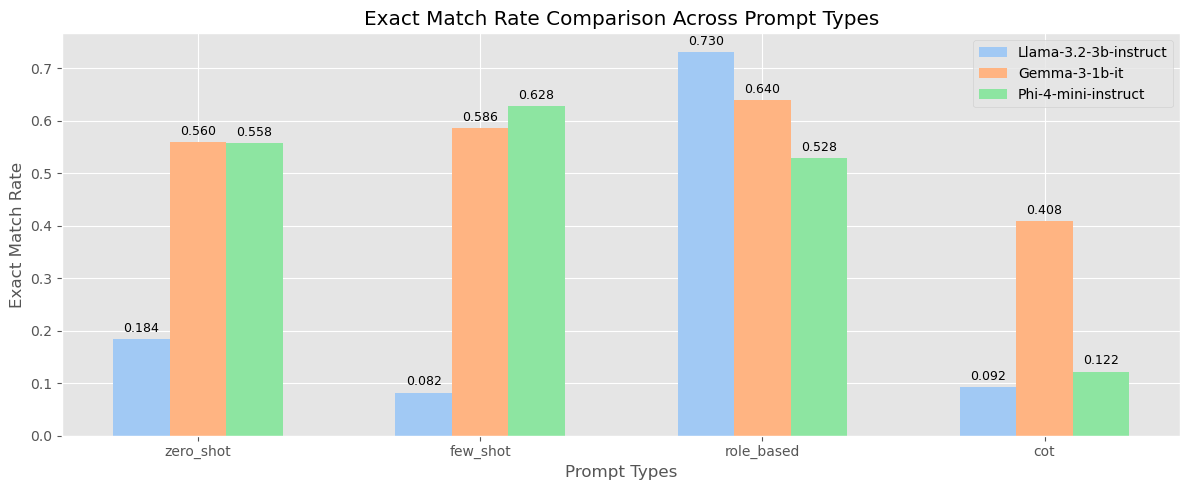

In [35]:
# Create visualization for Exact Match comparison
plt.figure(figsize=(12, 5))
sns.set_palette("pastel")

prompt_types = list(prompt_templates.keys())
x = np.arange(len(prompt_types))
width = 0.2 
models = list(results.keys())

# Create the bar plot and save the containers
containers = []
for i, model_name in enumerate(models):
    exact_match_scores = [summary[model_name][pt]["exact_match"] for pt in prompt_types]
    container = plt.bar(x + (i - 1) * width, exact_match_scores, width, label=model_name.capitalize())
    containers.append(container)

plt.xlabel('Prompt Types')
plt.ylabel('Exact Match Rate')
plt.title('Exact Match Rate Comparison Across Prompt Types')
plt.xticks(x, prompt_types)
plt.legend()

# Add labels on top of each bar
for container in containers:
    plt.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('exact_match_comparison.png')
plt.show()

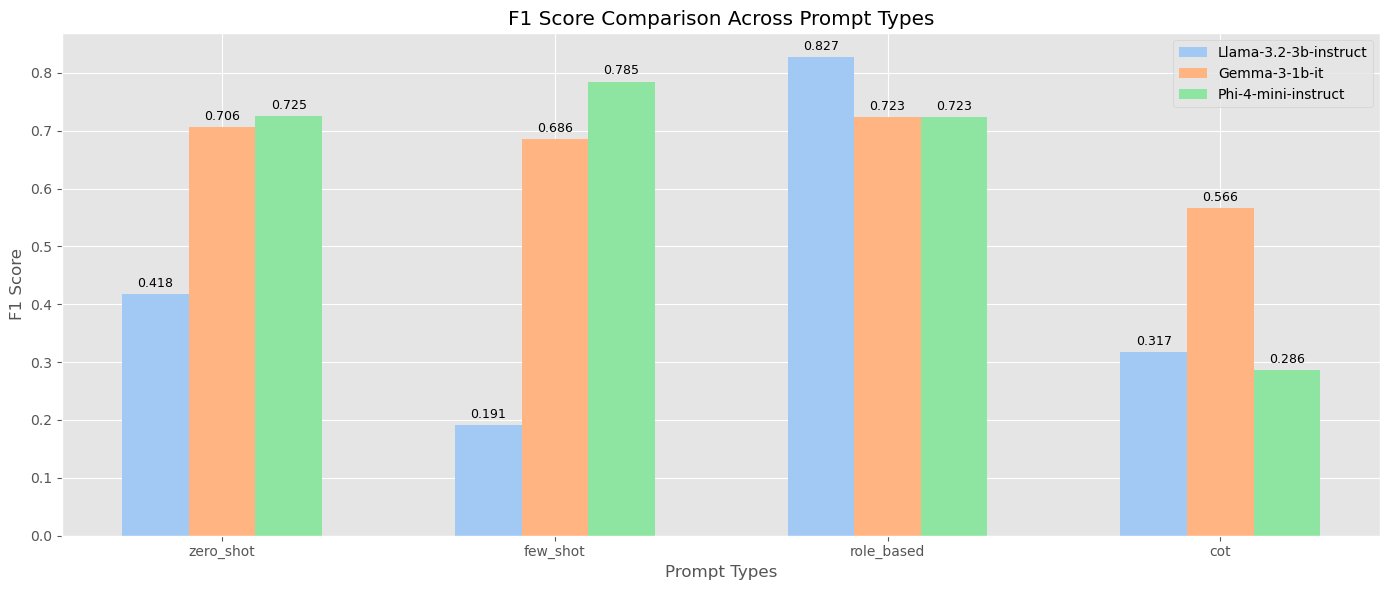

In [36]:
# Create visualization for F1 Score comparison
plt.figure(figsize=(14, 6))
sns.set_palette("pastel")

# Create the bar plot and save the containers
containers = []
for i, model_name in enumerate(models):
    f1_scores = [summary[model_name][pt]["f1"] for pt in prompt_types]
    container = plt.bar(x + (i - 1) * width, f1_scores, width, label=model_name.capitalize())
    containers.append(container)

plt.xlabel('Prompt Types')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Prompt Types')
plt.xticks(x, prompt_types)
plt.legend()

# Add labels on top of each bar
for container in containers:
    plt.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('f1_score_comparison.png')
plt.show()

### 5.3 EM and F1 Across Models

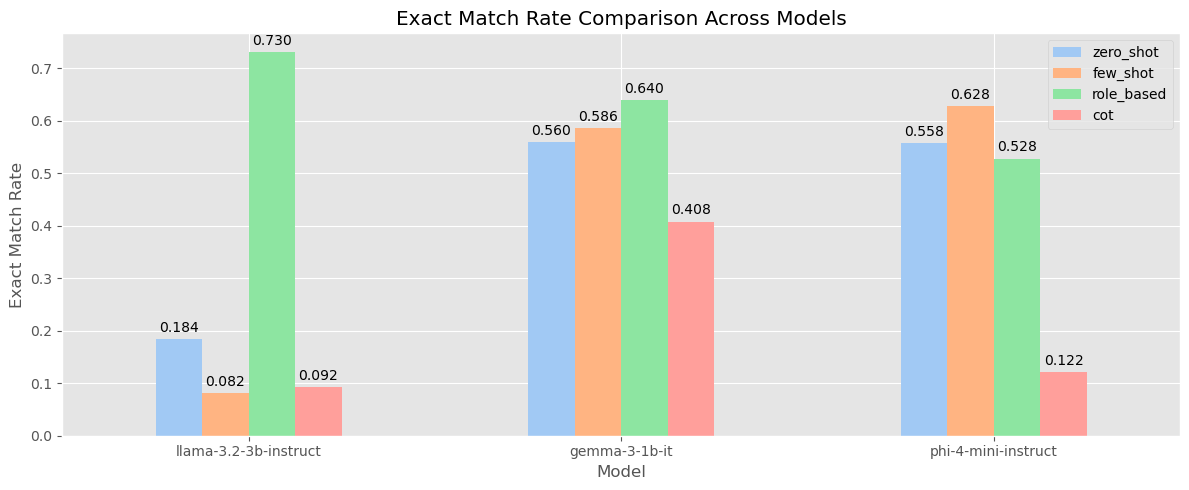

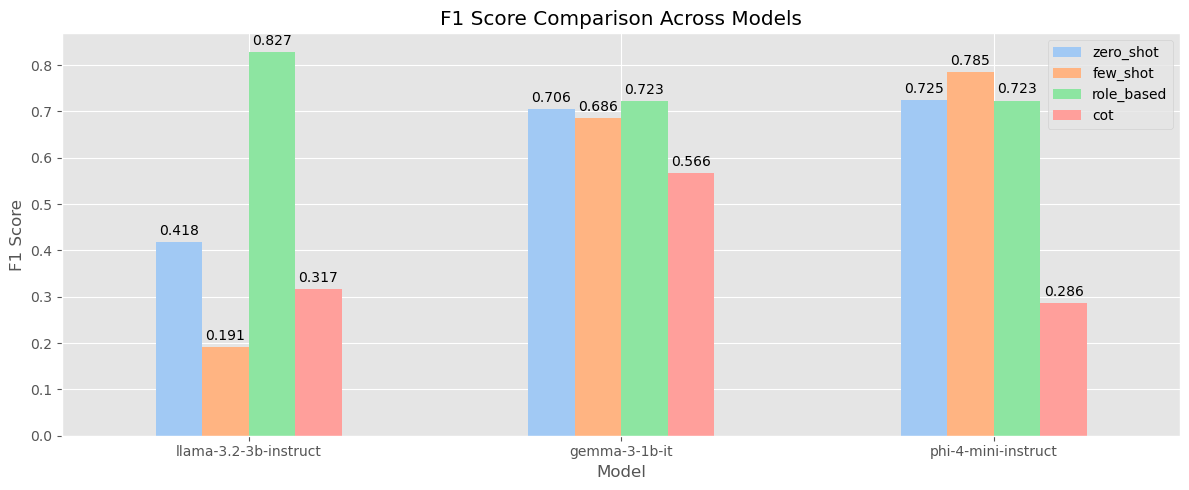

In [25]:
# Set up the visualization style
plt.style.use('ggplot')
sns.set_palette("pastel")

# Function to create a grouped bar chart
def plot_performance_comparison(data, metric_name, title):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Plot the data
    data.plot(kind='bar', ax=ax)
    
    # Add labels and title
    ax.set_xlabel('Model')
    ax.set_ylabel(metric_name)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    return fig

# Create the visualizations
exact_match_fig = plot_performance_comparison(
    exact_match_table, 
    'Exact Match Rate', 
    'Exact Match Rate Comparison Across Models'
)

f1_fig = plot_performance_comparison(
    f1_table, 
    'F1 Score', 
    'F1 Score Comparison Across Models'
)

# Save the figures
exact_match_fig.savefig('exact_match_comparison_detailed.png')
f1_fig.savefig('f1_score_comparison_detailed.png')


### 5.4 Prompt Type Difference Analysis

In [26]:
def find_divergent_cases(results, min_difference=0.5):
    """Find examples where different prompt types produced notably different results."""
    divergent_cases = {}
    
    for model_name in results:
        model_divergent = []
        
        # Get all example IDs for this model
        example_ids = set([item["example_id"] for item in results[model_name]["zero_shot"]])
        
        for ex_id in example_ids:
            # Collect performance and predictions for each prompt type
            case_data = {}
            for prompt_type in results[model_name]:
                for item in results[model_name][prompt_type]:
                    if item["example_id"] == ex_id:
                        case_data[prompt_type] = {
                            "f1": item["metrics"]["f1"],
                            "prediction": item["prediction"]
                        }
                        # Keep context, question, ground_truth for reference
                        context = item["context"]
                        question = item["question"]
                        ground_truth = item["ground_truth"]
                        break
            
            # Calculate max difference in F1 scores
            f1_scores = [data["f1"] for data in case_data.values()]
            max_diff = max(f1_scores) - min(f1_scores)
            
            if max_diff >= min_difference:
                divergent_case = {
                    "context": context,
                    "question": question,
                    "ground_truth": ground_truth,
                    "model_name": model_name,
                    "prompt_results": case_data,
                    "max_diff": max_diff
                }
                model_divergent.append(divergent_case)
        
        divergent_cases[model_name] = model_divergent
    
    return divergent_cases

# Find cases with divergent results across prompt types
divergent_cases = find_divergent_cases(results, min_difference=0.7)

# Display a few divergent cases for each model
for model_name, cases in divergent_cases.items():
    print(f"\nDivergent Cases for {model_name}:")
    
    # Sort by max difference
    sorted_cases = sorted(cases, key=lambda x: x['max_diff'], reverse=True)
    
    # Display top 5 cases
    for i, case in enumerate(sorted_cases[:10]):
        print(f"\nCase {i+1}:")
        # print(f"Context: {case['context']}")
        print(f"Question: {case['question']}")
        print(f"Ground Truth: {case['ground_truth']}")
        print(f"Max F1 Difference: {case['max_diff']:.4f}")
        
        print("Results by prompt type:")
        for prompt_type, data in case["prompt_results"].items():
            print(f"  {prompt_type}: F1={data['f1']:.4f}, Prediction='{data['prediction']}'")


Divergent Cases for llama-3.2-3b-instruct:

Case 1:
Question: What color was used to emphasize the 50th anniversary of the Super Bowl?
Ground Truth: gold
Max F1 Difference: 1.0000
Results by prompt type:
  zero_shot: F1=0.1818, Prediction='Gold was used to emphasize the 50th anniversary of the Super Bowl.'
  few_shot: F1=0.0000, Prediction='Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the '
  role_based: F1=1.0000, Prediction='Gold.'
  cot: F1=0.1667, Prediction='The color used to emphasize the 50th anniversary of the Super Bowl is gold.'

Case 2:
Question: Which team won Super Bowl 50.
G

### 5.5 find prompt type difference cases

In [28]:
def find_prompt_type_difference_cases(results, prompt_type1, prompt_type2, model_name, f1_diff_threshold=0.5, min_good_f1=0.5):
    """
    Find examples where one prompt type performs significantly better than another prompt type
    based on F1 scores.
    
    Args:
        results: Dictionary containing the evaluation results
        prompt_type1: First prompt type to compare
        prompt_type2: Second prompt type to compare  
        model_name: Name of the model to analyze
        f1_diff_threshold: Minimum difference in F1 scores to consider (default: 0.5)
        min_good_f1: Minimum F1 score for the better-performing prompt type (default: 0.5)
        
    Returns:
        List of dictionaries containing details about the identified cases with significant differences
    """
    difference_cases = []
    
    # Get all example IDs for this model
    example_ids = set([item["example_id"] for item in results[model_name][prompt_type1]])
    
    for ex_id in example_ids:
        # Find results for both prompt types for this example
        type1_item = None
        type2_item = None
        
        for item in results[model_name][prompt_type1]:
            if item["example_id"] == ex_id:
                type1_item = item
                break
                
        for item in results[model_name][prompt_type2]:
            if item["example_id"] == ex_id:
                type2_item = item
                break
        
        # If we found both, check if there's a significant difference
        if type1_item and type2_item:
            type1_f1 = type1_item["metrics"]["f1"]
            type2_f1 = type2_item["metrics"]["f1"]
            f1_diff = type1_f1 - type2_f1
            
            # Check if prompt_type1 is significantly better than prompt_type2
            if f1_diff >= f1_diff_threshold and type1_f1 >= min_good_f1:
                case = {
                    "example_id": ex_id,
                    "context": type1_item["context"],
                    "question": type1_item["question"],
                    "ground_truth": type1_item["ground_truth"],
                    prompt_type1: {
                        "prediction": type1_item["prediction"],
                        "f1": type1_f1,
                        "exact_match": type1_item["metrics"]["exact_match"]
                    },
                    prompt_type2: {
                        "prediction": type2_item["prediction"],
                        "f1": type2_f1,
                        "exact_match": type2_item["metrics"]["exact_match"]
                    },
                    "better_prompt": prompt_type1,
                    "f1_difference": f1_diff
                }
                difference_cases.append(case)
            
            # Check if prompt_type2 is significantly better than prompt_type1
            elif -f1_diff >= f1_diff_threshold and type2_f1 >= min_good_f1:
                case = {
                    "example_id": ex_id,
                    "context": type1_item["context"],
                    "question": type1_item["question"],
                    "ground_truth": type1_item["ground_truth"],
                    prompt_type1: {
                        "prediction": type1_item["prediction"],
                        "f1": type1_f1,
                        "exact_match": type1_item["metrics"]["exact_match"]
                    },
                    prompt_type2: {
                        "prediction": type2_item["prediction"],
                        "f1": type2_f1,
                        "exact_match": type2_item["metrics"]["exact_match"]
                    },
                    "better_prompt": prompt_type2,
                    "f1_difference": -f1_diff  # Make positive for easier comparison
                }
                difference_cases.append(case)
    
    # Sort by F1 difference (largest first)
    return sorted(difference_cases, key=lambda x: x["f1_difference"], reverse=True)


# Compare zero_shot and few_shot with a threshold of 0.7
significant_differences = find_prompt_type_difference_cases(
    results, "zero_shot", "few_shot", "llama-3.2-3b-instruct",
      f1_diff_threshold=0.7
)

# Display top 5 cases with the largest differences
for i, case in enumerate(significant_differences[:20]):
    print(f"\nCase {i+1}:")
    print(f"Question: {case['question']}")
    print(f"Ground Truth: {case['ground_truth']}")
    print(f"Better prompt: {case['better_prompt']}")
    print(f"F1 Difference: {case['f1_difference']:.4f}")
    print(f"Zero-shot: F1={case['zero_shot']['f1']:.4f}, Prediction='{case['zero_shot']['prediction']}'")
    print(f"Few-shot: F1={case['few_shot']['f1']:.4f}, Prediction='{case['few_shot']['prediction']}'")


Case 1:
Question: How many times was Cam Newton sacked?
Ground Truth: seven
Better prompt: few_shot
F1 Difference: 1.0000
Zero-shot: F1=0.0000, Prediction='Cam Newton was sacked 7 times.'
Few-shot: F1=1.0000, Prediction='Seven.'

Case 2:
Question: How many times was the Panthers' quarterback sacked?
Ground Truth: seven
Better prompt: few_shot
F1 Difference: 1.0000
Zero-shot: F1=0.0000, Prediction='The Denver Broncos' defense sacked the Panthers' quarterback 7 times.'
Few-shot: F1=1.0000, Prediction='Seven.'

Case 3:
Question: Which Super Bowl was hosted in San Diego in 2003? 
Ground Truth: Super Bowl XXXVII
Better prompt: zero_shot
F1 Difference: 1.0000
Zero-shot: F1=1.0000, Prediction='Super Bowl XXXVII.'
Few-shot: F1=0.0000, Prediction='Example 1:
Context: The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Buildi

In [29]:
# def analyze_prompt_type_differences(results, model_name="gemma-3-1b-it", f1_diff_threshold=0.5):
#     """
#     Analyze differences between various prompt types for a given model
#     """
#     prompt_types = ["zero_shot", "few_shot", "role_based", "cot"]
    
#     print(f"\nPrompt Type Difference Analysis for {model_name}:")
    
#     # Compare each prompt type with every other prompt type
#     for i in range(len(prompt_types)):
#         for j in range(i+1, len(prompt_types)):
#             type1 = prompt_types[i]
#             type2 = prompt_types[j]
            
#             print(f"\nComparing {type1} vs {type2}:")
#             difference_cases = find_prompt_type_difference_cases(
#                 results, type1, type2, model_name, f1_diff_threshold
#             )
            
#             if not difference_cases:
#                 print(f"No significant differences found with threshold {f1_diff_threshold}")
#                 continue
                
#             # Get cases where type1 is better
#             type1_better = [case for case in difference_cases if case["better_prompt"] == type1]
#             # Get cases where type2 is better
#             type2_better = [case for case in difference_cases if case["better_prompt"] == type2]
            
#             print(f"Found {len(type1_better)} cases where {type1} is better than {type2}")
#             print(f"Found {len(type2_better)} cases where {type2} is better than {type1}")
            
#             # Display a few examples for each
#             if type1_better:
#                 print(f"\nTop 3 examples where {type1} is better than {type2}:")
#                 for i, case in enumerate(type1_better[:3]):
#                     print(f"\nCase {i+1}:")
#                     print(f"Question: {case['question']}")
#                     print(f"Ground Truth: {case['ground_truth']}")
#                     print(f"F1 Difference: {case['f1_difference']:.4f}")
#                     print(f"{type1}: F1={case[type1]['f1']:.4f}, Prediction='{case[type1]['prediction']}'")
#                     print(f"{type2}: F1={case[type2]['f1']:.4f}, Prediction='{case[type2]['prediction']}'")
            
#             if type2_better:
#                 print(f"\nTop 3 examples where {type2} is better than {type1}:")
#                 for i, case in enumerate(type2_better[:3]):
#                     print(f"\nCase {i+1}:")
#                     print(f"Question: {case['question']}")
#                     print(f"Ground Truth: {case['ground_truth']}")
#                     print(f"F1 Difference: {case['f1_difference']:.4f}")
#                     print(f"{type2}: F1={case[type2]['f1']:.4f}, Prediction='{case[type2]['prediction']}'")
#                     print(f"{type1}: F1={case[type1]['f1']:.4f}, Prediction='{case[type1]['prediction']}'")

# # Analyze all prompt type differences for the Gemma model
# analyze_prompt_type_differences(results, "gemma-3-1b-it", 0.5)

### 5.6 Prompt Design Bias Analysis


Raw data for phi-4-mini-instruct model prompt bias analysis:
     prompt_type question_type      f1  exact_match
0      zero_shot         other  1.0000            1
1      zero_shot         other  1.0000            1
2      zero_shot         where  0.4286            0
3      zero_shot         other  1.0000            1
4      zero_shot          what  1.0000            1
...          ...           ...     ...          ...
1995         cot          when  0.1538            0
1996         cot          what  0.1143            0
1997         cot         where  0.6667            0
1998         cot          what  0.7500            0
1999         cot          what  0.0588            0

[2000 rows x 4 columns]

Average F1 scores by prompt type and question type:
   prompt_type question_type        f1
0          cot           how  0.144419
1          cot         other  0.314849
2          cot          what  0.273734
3          cot          when  0.365063
4          cot         where  0.426820
5 

<Figure size 1400x800 with 0 Axes>

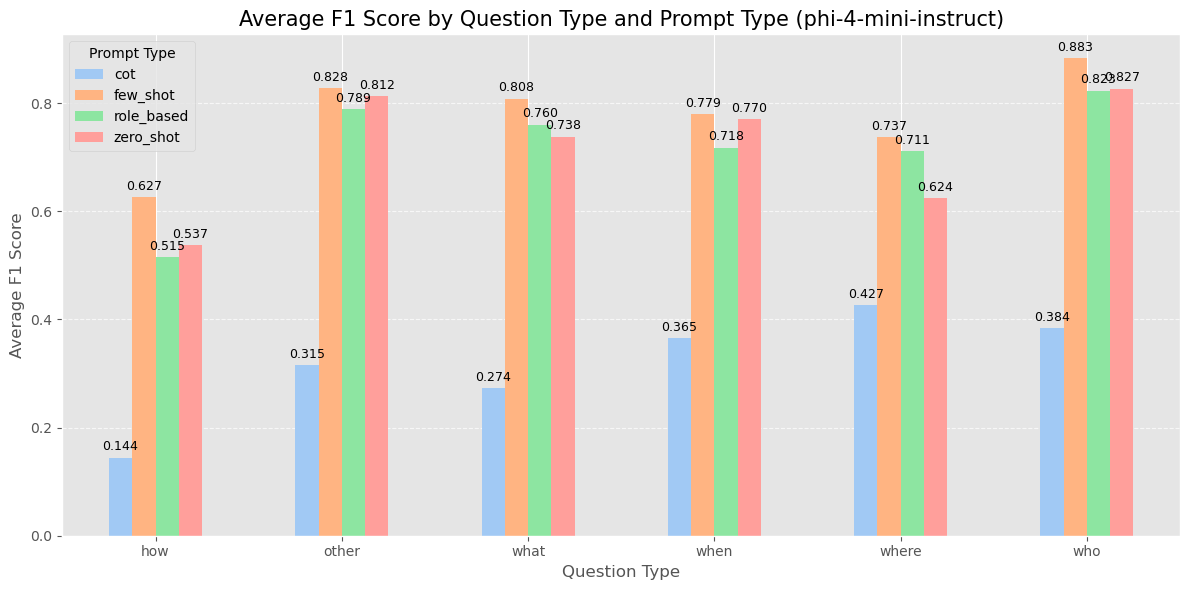

In [32]:
EXAMPLE_MODEL = "phi-4-mini-instruct"

def analyze_prompt_bias_llama(results):
    """Analyze if certain prompt types favor specific types of questions for Llama model only."""
    # Categorize questions by type
    def categorize_question(question):
        question = question.lower()
        if question.startswith('who'):
            return 'who'
        elif question.startswith('what'):
            return 'what'
        elif question.startswith('when'):
            return 'when'
        elif question.startswith('where'):
            return 'where'
        elif question.startswith('why'):
            return 'why'
        elif question.startswith('how'):
            return 'how'
        else:
            return 'other'
    
    bias_data = []
    
    # Extract only Llama model data
    example_model = EXAMPLE_MODEL
    
    for prompt_type in results[example_model]:
        for item in results[example_model][prompt_type]:
            question_type = categorize_question(item["question"])
            
            bias_data.append({
                "prompt_type": prompt_type,
                "question_type": question_type,
                "f1": item["metrics"]["f1"],
                "exact_match": item["metrics"]["exact_match"]
            })
    
    return pd.DataFrame(bias_data)

# Analyze prompt bias by question type for Llama model only
llama_bias_df = analyze_prompt_bias_llama(results)

# Print the raw data frame
print(f"\nRaw data for {EXAMPLE_MODEL} model prompt bias analysis:")
print(llama_bias_df)

# Create a grouped bar chart instead of heatmap
plt.figure(figsize=(14, 8))

# Calculate average F1 score by prompt type and question type
avg_f1_by_type = llama_bias_df.groupby(['prompt_type', 'question_type'])['f1'].mean().reset_index()

# Print the aggregated data
print("\nAverage F1 scores by prompt type and question type:")
print(avg_f1_by_type)

# Pivot the data for easier plotting
pivot_data = avg_f1_by_type.pivot(index='question_type', columns='prompt_type', values='f1')

# Print the pivoted data
print("\nPivoted data for plotting:")
print(pivot_data)

# Plot with question types on x-axis and different colors for prompt types
ax = pivot_data.plot(kind='bar', figsize=(12, 6))
plt.title(f'Average F1 Score by Question Type and Prompt Type ({EXAMPLE_MODEL})', fontsize=15)
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Average F1 Score', fontsize=12)
plt.legend(title='Prompt Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('llama_question_type_bias_barchart.png')

# Calculate the "best" prompt type for each question type
best_prompt_by_question = avg_f1_by_type.loc[avg_f1_by_type.groupby('question_type')['f1'].idxmax()]
best_prompt_by_question = best_prompt_by_question.sort_values('f1', ascending=False)

print("\nBest Prompt Type for Each Question Type:")
for _, row in best_prompt_by_question.iterrows():
    print(f"Question type '{row['question_type']}': Best prompt is '{row['prompt_type']}' (F1={row['f1']:.3f})")

# Calculate overall prompt type performance
overall_prompt_performance = llama_bias_df.groupby('prompt_type')['f1'].mean().sort_values(ascending=False)
print("\nOverall Prompt Type Performance:")
for prompt_type, avg_f1 in overall_prompt_performance.items():
    print(f"Prompt type '{prompt_type}': Average F1={avg_f1:.3f}")

# Print detailed statistics for each prompt type and question type combination
print("\nDetailed Statistics by Prompt Type and Question Type:")
detailed_stats = llama_bias_df.groupby(['prompt_type', 'question_type']).agg({
    'f1': ['mean', 'std', 'min', 'max', 'count'],
    'exact_match': ['mean', 'sum', 'count']
}).round(3)
print(detailed_stats)

# Print correlation between metrics
print("\nCorrelation between F1 and Exact Match:")
print(llama_bias_df[['f1', 'exact_match']].corr())